In [3]:
import pandas as pd

# Load the dataset and remove the first row (blank row)
file_path = '/Users/takaya/Desktop/app_wonder_palette/new_product/grs/AI需要予測送付用 (9).xlsx'
data = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=1, header=None)

# Extract the first column as the date/label column
date_and_labels = data.iloc[:, 0]  # First column

# Create 商品ID and 商品ID_名前 excluding the first column
商品ID = data.iloc[0, 1:].astype(str) + '_' + data.iloc[2, 1:].astype(str) + '_' + \
         data.iloc[4, 1:].astype(str) + '_' + data.iloc[6, 1:].astype(str)
商品ID_名前 = data.iloc[1, 1:].astype(str) + '_' + data.iloc[3, 1:].astype(str) + '_' + \
             data.iloc[5, 1:].astype(str) + '_' + data.iloc[7, 1:].astype(str)

# Replace "nan" with empty strings
商品ID_名前 = 商品ID_名前.str.replace('nan', '', regex=False)

# Extract sales data starting from the 10th row (1-indexed), excluding the first column
sales_data_start_row = 9  # Row 10 in Excel
sales_data = data.iloc[sales_data_start_row:, 1:].reset_index(drop=True)

# Extract actual sales dates from the first column
sales_dates = pd.to_datetime(date_and_labels.iloc[sales_data_start_row:], errors='coerce')
sales_dates = sales_dates.reset_index(drop=True)

# Assign 商品ID_名前 as the headers for the sales data
sales_data.columns = 商品ID_名前

# Add the extracted sales dates as the Date column
sales_data.insert(0, 'Date', sales_dates)

# Convert the dataset into long format
long_format = sales_data.melt(
    id_vars=['Date'],  # Keep the Date column as identifier
    var_name='商品ID_名前',  # Use 商品ID_名前 as the column name for variable
    value_name='Sales'  # The sales values
)

long_format['Sales'] = long_format['Sales'].fillna(0)

# Save the updated dataset to a new Excel file
# output_path = 'test.xlsx'
# sales_data.to_excel(output_path, index=False)

In [4]:
# Define training and test date ranges
train_start_date = pd.Timestamp('2022-01-20')
train_end_date = pd.Timestamp('2024-11-24')
test_start_date = pd.Timestamp('2024-11-25')
test_end_date = pd.Timestamp('2025-01-19')

# Split the data into training and test sets
train_data = long_format[(long_format['Date'] >= train_start_date) & (long_format['Date'] <= train_end_date)]
test_data = long_format[(long_format['Date'] >= test_start_date) & (long_format['Date'] <= test_end_date)]

In [62]:
from collections import defaultdict
import pandas as pd

# Initialize a dictionary to count failures for each criterion
failure_counts = defaultdict(int)

# Define the training start date
train_start_date = pd.Timestamp('2022-01-20')

# Function to validate a product group
def validate_product(group):
    global failure_counts  # Use global to update counts outside the function
    
    # Filter for non-zero sales data
    non_zero_sales = group[group['Sales'] > 0]
    
    # Criterion 1: Valid duration (Start and end of non-zero sales)
    if non_zero_sales.empty:
        failure_counts['No Non-Zero Sales'] += 1
        return False
    
    duration = (non_zero_sales['Date'].max() - non_zero_sales['Date'].min()).days
    if duration < (365 + 30):  # 1 year and 1 month
        failure_counts['Invalid Duration'] += 1
        return False
    
    # Criterion 2: Non-zero rate from start of non-zero data
    non_zero_start_date = non_zero_sales['Date'].min()
    relevant_data = group[group['Date'] >= non_zero_start_date]  # Data after the first non-zero sale
    non_zero_rate = (relevant_data['Sales'] > 0).mean()
    
    if non_zero_rate <= 0.80:
        failure_counts['Low Non-Zero Rate'] += 1
        return False

    # Criterion 3: Sales at start of training (First three-days sales must be all zero)
    first_week_sales = group[(group['Date'] >= train_start_date) & 
                             (group['Date'] < train_start_date + pd.Timedelta(days=30))]
    if not (first_week_sales['Sales'] == 0).all():
        failure_counts['Non-Zero Sales in First Week'] += 1
        return False
    
    return True

# Function to find all seed product candidates
def get_all_seed_candidates(data):
    seed_candidates = []
    grouped = data.groupby('商品ID_名前')
    
    for product, group in grouped:
        # Validate the product
        if validate_product(group):
            seed_candidates.append(product)
    
    return seed_candidates

# Function to find seed products for a specific target product
def find_seed_product(target_product, seed_candidates):
    # Pre-check: Ensure the target product exists in the training dataset
    if target_product not in train_data['商品ID_名前'].values:
        print(f"Target product '{target_product}' does not exist in the training dataset.")
        return []
    
    # Split 商品ID_名前 into elements for comparison
    target_elements = target_product.split('_')
    
    # Define levels of similarity
    similarity_levels = [
        lambda x: x == target_product,  # Exact match
        lambda x: '_'.join(x.split('_')[:3]) == '_'.join(target_elements[:3]),  # First 3 elements match
        lambda x: '_'.join(x.split('_')[:2]) == '_'.join(target_elements[:2]),  # First 2 elements match
        lambda x: x.split('_')[0] == target_elements[0],  # First element matches
    ]
    
    # Iterate through similarity levels
    for level in similarity_levels:
        similar_products = [prod for prod in seed_candidates if level(prod)]
        if len(similar_products) >= 2:
            print(f"Seed products found for '{target_product}': {similar_products}")
            return similar_products
    
    # If no matches found
    print(f"No seed products found for '{target_product}'.")
    return []

# Step 1: Find all seed product candidates
seed_candidates = get_all_seed_candidates(train_data)
print("number of seed candidates:", len(seed_candidates))

# Display failure counts for each criterion
print("\nFailure Counts for Each Criterion:")
for criterion, count in failure_counts.items():
    print(f"{criterion}: {count}")


number of seed candidates: 96

Failure Counts for Each Criterion:
Invalid Duration: 1262
No Non-Zero Sales: 67
Low Non-Zero Rate: 909
Non-Zero Sales in First Week: 199


In [63]:
# Step 2: Find seed products for a specific target product
#target_product = "【卸】首都圏駅（JR東日本他）_東京ばな奈ワールド_ばな奈Wその他単品_東京ばな奈クリスピーミルク"
#target_product = "【直】駅_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごピスタサンド"
target_product = "【卸】EC_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごﾐﾙｸｻﾝﾄﾞ"

seed_products = find_seed_product(target_product, seed_candidates)


seed_products

Seed products found for '【卸】EC_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごﾐﾙｸｻﾝﾄﾞ': ['【卸】EC_ねんりん家_マウントバーム_MTしっかり芽', '【卸】EC_シュガーバターの木_SBTの実_SBTの実', '【卸】EC_東京ばな奈ワールド_銀座のケーキ_銀座のいちご', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂその他焼菓子_バターショコラサンド', '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂｸｯｷｰ_バターステイツクッキー', '【卸】EC_鎌倉五郎_サンドだょ_チョコサンドだょ']


['【卸】EC_ねんりん家_マウントバーム_MTしっかり芽',
 '【卸】EC_シュガーバターの木_SBTの実_SBTの実',
 '【卸】EC_東京ばな奈ワールド_銀座のケーキ_銀座のいちご',
 '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂその他焼菓子_バターショコラサンド',
 '【卸】EC_銀のぶどう(ﾊﾞﾀｰｽﾃｲﾂ)_ﾊﾞﾀｰｽﾃｲﾂｸｯｷｰ_バターステイツクッキー',
 '【卸】EC_鎌倉五郎_サンドだょ_チョコサンドだょ']

In [65]:
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning


def calculate_sales_ratios_with_weighted_scaling(group):
    """
    Calculate sales ratios for a seed product, including:
    - Scaling for additional durations.
    - Taking the weighted average for the same day-month across multiple years.

    Args:
    - group: A DataFrame group representing sales data for a single product.

    Returns:
    - A DataFrame with calculated ratios.
    """
    # Filter non-zero sales data
    non_zero_sales = group[group['Sales'] > 0]
    if non_zero_sales.empty:
        return pd.DataFrame()  # No data to process

    # Start and end of non-zero sales
    start_date = non_zero_sales['Date'].min()
    print("start_date:", start_date)
    end_date = non_zero_sales['Date'].max()
    print("end_date:", end_date)

    # Initialize the result DataFrame
    result = pd.DataFrame(columns=['Date', 'Ratio', 'Adjusted_Ratio'])

    # Process full years and additional durations
    current_start = start_date
    # Define the current year's duration
    next_year_start = current_start + pd.Timedelta(days=365)
    current_year_data = group[(group['Date'] >= current_start) & (group['Date'] < next_year_start)]

    # Compute the daily sales ratio for the current year
    if not current_year_data.empty:
        total_sales = current_year_data['Sales'].sum()
        current_year_data['Ratio'] = current_year_data['Sales'] / total_sales
        result = pd.concat([result, current_year_data[['Date', 'Ratio']]])
        print("ratio for first year", result["Ratio"].sum())
    while next_year_start <= end_date:
        # Handle additional durations (extra years or months)
        if next_year_start <= end_date:
            extra_duration_end = min(next_year_start + pd.Timedelta(days=365), end_date)
            extra_duration_data = group[(group['Date'] >= next_year_start) & (group['Date'] <= extra_duration_end)]
            #print("extra_duration_data:", extra_duration_data)

            if not extra_duration_data.empty:
                # Calculate initial ratios for the additional duration
                extra_total_sales = extra_duration_data['Sales'].sum()
                extra_duration_data['Ratio'] = extra_duration_data['Sales'] / extra_total_sales

                # Determine equivalent period in the previous year for scaling
                #prev_start = next_year_start - pd.Timedelta(days=(extra_duration_end - next_year_start).days)
                prev_start = next_year_start - pd.Timedelta(days=365)
                print("prev_start:", prev_start)
                prev_end = min(next_year_start, end_date - pd.Timedelta(days=365))
                print("prev_end:", prev_end)
                previous_year_data = group[(group['Date'] >= prev_start) & (group['Date'] <= prev_end)]

                if not previous_year_data.empty:
                    previous_year_total = previous_year_data['Sales'].sum()
                    scaling_factor = previous_year_total / total_sales if total_sales > 0 else 1
                    print("scaling_factor:", scaling_factor)
                    extra_duration_data['Adjusted_Ratio'] = extra_duration_data['Ratio'] * scaling_factor
                else:
                    extra_duration_data['Adjusted_Ratio'] = extra_duration_data['Ratio']  # No scaling available

                # Add the scaled ratios to the result
                result = pd.concat([result, extra_duration_data[['Date', 'Ratio', 'Adjusted_Ratio']]])
                print("ratio_sum_inside_for_loop", result["Ratio"].sum())
                
        next_year_start = next_year_start + pd.Timedelta(days=365)

    # Compute averages for the same day-month across all years with weighted averaging
    result['Day-Month'] = result['Date'].dt.strftime('%m-%d')
    #print("ratio_sum_after_loop", result["Ratio"].sum())

    # Compute Weighted Average Ratio: Prioritizing Adjusted_Ratio if available
    result['Weighted_Average_Ratio'] = result.apply(
        lambda row: row['Adjusted_Ratio'] if not pd.isnull(row['Adjusted_Ratio']) else row['Ratio'],
        axis=1
    )
    print("weighted_ratio_sum", result["Weighted_Average_Ratio"].sum())
    print("ratio_sum", result["Ratio"].sum())
    print("Adjusted ratio sum:", result["Adjusted_Ratio"].sum())

    result['Weighted_Average_Ratio'] = result.groupby('Day-Month')['Weighted_Average_Ratio'].transform('mean')


    return result

# Process each seed product
all_results = []
for seed_product in seed_products:
    print(f"Processing seed product: {seed_product}")
    product_data = train_data[train_data['商品ID_名前'] == seed_product]

    # Calculate sales ratios with scaling and average
    sales_ratios = calculate_sales_ratios_with_weighted_scaling(product_data)
    sales_ratios['Seed_Product'] = seed_product  # Add seed product name for reference
    all_results.append(sales_ratios)

# Convert list to DataFrame
final_results = pd.concat(all_results, ignore_index=True)

# Ensure "Day-Month" exists before aggregation
if 'Day-Month' not in final_results.columns:
    final_results['Day-Month'] = final_results['Date'].dt.strftime('%m-%d')

# Compute the overall average of weighted average ratios across all seed products
seed_365_avg = final_results.groupby('Day-Month')['Weighted_Average_Ratio'].mean().reset_index()
seed_365_avg.rename(columns={'Weighted_Average_Ratio': 'シード商品365日構成比'}, inplace=True)

print(seed_365_avg['シード商品365日構成比'].sum())

# Save to Excel
final_results_output_path = "seed_products_sales_ratios_with_scaling_and_average.xlsx"
seed_365_avg_output_path = "シード商品365日構成比.xlsx"

final_results.to_excel(final_results_output_path, index=False)
seed_365_avg.to_excel(seed_365_avg_output_path, index=False)

print(f"Sales ratios for seed products saved to {final_results_output_path}")
print(f"シード商品365日構成比 saved to {seed_365_avg_output_path}")



Processing seed product: 【卸】EC_ねんりん家_マウントバーム_MTしっかり芽
start_date: 2022-12-03 00:00:00
end_date: 2024-11-24 00:00:00
ratio for first year 1.0
prev_start: 2022-12-03 00:00:00
prev_end: 2023-11-25 00:00:00
scaling_factor: 0.9649762408303764
ratio_sum_inside_for_loop 2.0
weighted_ratio_sum 1.9649762408303764
ratio_sum 2.0
Adjusted ratio sum: 0.9649762408303764
Processing seed product: 【卸】EC_シュガーバターの木_SBTの実_SBTの実
start_date: 2022-12-15 00:00:00
end_date: 2024-11-24 00:00:00
ratio for first year 1.0
prev_start: 2022-12-15 00:00:00
prev_end: 2023-11-25 00:00:00
scaling_factor: 0.9450295402003597
ratio_sum_inside_for_loop 2.0
weighted_ratio_sum 1.9450295402003597
ratio_sum 2.0
Adjusted ratio sum: 0.9450295402003597
Processing seed product: 【卸】EC_東京ばな奈ワールド_銀座のケーキ_銀座のいちご
start_date: 2023-03-04 00:00:00
end_date: 2024-11-24 00:00:00
ratio for first year 1.0
prev_start: 2023-03-04 00:00:00
prev_end: 2023-11-25 00:00:00
scaling_factor: 0.727542205266726
ratio_sum_inside_for_loop 2.0
weighted_ratio_s

In [66]:
import pandas as pd

def process_seed_product_ratios_with_sales(final_results, train_data, seed_products):
    """
    Rescale ratios, retrieve actual sales, and calculate the change rate for each day,
    averaging across all seed products.

    Args:
    - final_results: DataFrame containing pre-calculated weighted ratios for all seed products.
    - train_data: DataFrame containing actual sales data.
    - seed_products: List of seed products.

    Returns:
    - DataFrame with the average change rate for each day since the first non-zero sales.
    """
    all_results = []

    for seed_product in seed_products:
        # Filter data for the seed product in final_results
        seed_product_ratios = final_results[final_results['Seed_Product'] == seed_product].copy()

        # Ensure the Date column is in datetime format
        seed_product_ratios['Date'] = pd.to_datetime(seed_product_ratios['Date'], errors='coerce')

        # Retrieve the actual sales data from train_data for the seed product
        seed_product_sales = train_data[train_data['商品ID_名前'] == seed_product].copy()
        seed_product_sales['Date'] = pd.to_datetime(seed_product_sales['Date'], errors='coerce')

        # Merge actual sales data with the ratios data on Date
        seed_product_data = pd.merge(
            seed_product_ratios, seed_product_sales[['Date', 'Sales']],
            on='Date', how='inner'
        )

        # Define the first and last non-zero sales dates
        first_non_zero_date = seed_product_data[seed_product_data['Weighted_Average_Ratio'] > 0]['Date'].min()
        last_non_zero_date = seed_product_data[seed_product_data['Weighted_Average_Ratio'] > 0]['Date'].max()

        # Rescale the weighted ratios so that the sum becomes 1
        total_ratio_sum = seed_product_data['Weighted_Average_Ratio'].sum()
        seed_product_data['Rescaled_Ratio'] = seed_product_data['Weighted_Average_Ratio'] / total_ratio_sum

        # Rescale the actual sales data for the entire duration
        total_actual_sales = seed_product_data['Sales'].sum()
        seed_product_data['Rescaled_Actual_Sales'] = seed_product_data['Sales'] / total_actual_sales

        # Calculate the change rate
        seed_product_data['Change_Rate'] = seed_product_data.apply(
            lambda row: row['Rescaled_Actual_Sales'] / row['Rescaled_Ratio']
            if row['Rescaled_Ratio'] > 0 else 0, axis=1
        )

        # Add a "Days Passed" column since the first non-zero sale
        seed_product_data['Days_Passed'] = (seed_product_data['Date'] - first_non_zero_date).dt.days

        # Append the processed data
        all_results.append(seed_product_data[['Days_Passed', 'Change_Rate']])

    # Combine results from all seed products
    combined_results = pd.concat(all_results, ignore_index=True)

    # Compute the overall average change rate across all products
    average_change_rate = combined_results.groupby('Days_Passed', as_index=False)['Change_Rate'].mean()

    # Apply a 7-day moving average to smooth the change rate
    average_change_rate['Smoothed_Change_Rate'] = average_change_rate['Change_Rate'].rolling(window=7, min_periods=1).mean()

    return average_change_rate

# Process and calculate the final average change rate
final_average_change_rate = process_seed_product_ratios_with_sales(final_results, train_data, seed_products)

# Save the final results to an Excel file
# final_output_path = "final_smoothed_average_change_rate.xlsx"
# final_average_change_rate.to_excel(final_output_path, index=False)

# print(f"Final smoothed average change rate saved to {final_output_path}")



In [67]:
import pandas as pd

def process_seed_product_ratios_with_sales(final_results, train_data, seed_products):
    """
    Rescale ratios, retrieve actual sales, and calculate the change rate for each day,
    averaging across all seed products. Applies a 7-day moving average to sales and ratios first,
    then calculates the change rate.

    Args:
    - final_results: DataFrame containing pre-calculated weighted ratios for all seed products.
    - train_data: DataFrame containing actual sales data.
    - seed_products: List of seed products.

    Returns:
    - DataFrame with the average change rate for each day since the first non-zero sales.
    """
    all_results = []

    for seed_product in seed_products:
        # Filter data for the seed product in final_results
        seed_product_ratios = final_results[final_results['Seed_Product'] == seed_product].copy()

        # Ensure the Date column is in datetime format
        seed_product_ratios['Date'] = pd.to_datetime(seed_product_ratios['Date'], errors='coerce')

        # Retrieve the actual sales data from train_data for the seed product
        seed_product_sales = train_data[train_data['商品ID_名前'] == seed_product].copy()
        seed_product_sales['Date'] = pd.to_datetime(seed_product_sales['Date'], errors='coerce')

        # Merge actual sales data with the ratios data on Date
        seed_product_data = pd.merge(
            seed_product_ratios, seed_product_sales[['Date', 'Sales']],
            on='Date', how='inner'
        )

        # Define the first and last non-zero sales dates
        first_non_zero_date = seed_product_data[seed_product_data['Weighted_Average_Ratio'] > 0]['Date'].min()

        # Apply 7-day moving average **before** calculating change rate
        seed_product_data['Sales_MA7'] = seed_product_data['Sales'].rolling(window=7, min_periods=1).mean()
        seed_product_data['Ratio_MA7'] = seed_product_data['Weighted_Average_Ratio'].rolling(window=7, min_periods=1).mean()

        # Rescale the weighted ratios so that the sum becomes 1
        total_ratio_sum = seed_product_data['Ratio_MA7'].sum()
        seed_product_data['Rescaled_Ratio'] = seed_product_data['Ratio_MA7'] / total_ratio_sum

        # Rescale the actual sales data for the entire duration
        total_actual_sales = seed_product_data['Sales_MA7'].sum()
        seed_product_data['Rescaled_Actual_Sales'] = seed_product_data['Sales_MA7'] / total_actual_sales

        # Calculate the change rate **after applying the 7-day moving average**
        seed_product_data['Change_Rate'] = seed_product_data.apply(
            lambda row: row['Rescaled_Actual_Sales'] / row['Rescaled_Ratio']
            if row['Rescaled_Ratio'] > 0 else 0, axis=1
        )

        # Add a "Days Passed" column since the first non-zero sale
        seed_product_data['Days_Passed'] = (seed_product_data['Date'] - first_non_zero_date).dt.days

        # Append the processed data
        all_results.append(seed_product_data[['Days_Passed', 'Change_Rate']])

    # Combine results from all seed products
    combined_results = pd.concat(all_results, ignore_index=True)

    # Compute the overall average change rate across all products
    average_change_rate = combined_results.groupby('Days_Passed', as_index=False)['Change_Rate'].mean()

    return average_change_rate

# Process and calculate the final average change rate
final_average_change_rate = process_seed_product_ratios_with_sales(final_results, train_data, seed_products)

# # Save the final results to an Excel file
# final_output_path = "final_moving_avg_change_rate.xlsx"
# final_average_change_rate.to_excel(final_output_path, index=False)

# print(f"Final moving average change rate saved to {final_output_path}")


In [68]:
import pandas as pd

def predict_new_product_sales_without_smoothing(
    train_data, final_results, seed_365_avg, change_rate, new_product_name, test_start, test_end
):
    """
    Predict sales for the test data period for a new product using the original change rates
    and averaged seed product 365-day composition ratios.

    Args:
    - train_data: DataFrame containing actual sales data for seed and new products.
    - final_results: DataFrame containing pre-calculated ratios for seed products.
    - seed_365_avg: DataFrame containing the averaged 365-day composition ratio for seed products.
    - change_rate: DataFrame containing the raw change rate (without smoothing).
    - new_product_name: Name of the new product to predict sales for.
    - test_start: Start date of the test period (YYYY-MM-DD).
    - test_end: End date of the test period (YYYY-MM-DD).

    Returns:
    - DataFrame with predicted sales for the new product during the test period.
    """

    # Ensure dates are in datetime format
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    train_data['Date'] = pd.to_datetime(train_data['Date'], errors='coerce')

    # Retrieve new product sales data
    new_product_data = train_data[train_data['商品ID_名前'] == new_product_name].copy()

    # Ensure non-zero sales for the new product
    non_zero_new_sales = new_product_data[new_product_data['Sales'] > 0]
    if non_zero_new_sales.empty:
        raise ValueError("No non-zero sales data available for the new product.")

    # Find the actual first non-zero date in the entire training dataset
    new_start_date = new_product_data.loc[new_product_data['Sales'] > 0, 'Date'].min()

    new_product_data = new_product_data[new_product_data['Date'] >= new_start_date]
    new_product_data['Days_Passed'] = (new_product_data['Date'] - new_start_date).dt.days

    # Merge new product data with the raw change rate (instead of smoothed)
    merged_data = pd.merge(new_product_data, change_rate, on='Days_Passed', how='left')

    # Rescale new product sales using the raw change rate
    merged_data['Adjusted_Sales'] = merged_data['Sales'] / merged_data['Change_Rate']

    # Compute scaling factor to match the seed product 365-day composition ratio
    seed_365_avg_copy = seed_365_avg.copy()

    # Extract the relevant duration from seed_365_avg_copy to match new product data duration
    start_day_month = new_start_date.strftime('%m-%d')
    end_day_month = merged_data['Date'].max().strftime('%m-%d')

    # Filter only the corresponding period in the seed product composition ratio,
    # accounting for cases where the period spans across two calendar years.
    if start_day_month <= end_day_month:
        # Case 1: The period is within a single year (e.g., 03-01 to 08-15)
        seed_365_avg_filtered = seed_365_avg_copy[
            (seed_365_avg_copy['Day-Month'] >= start_day_month) &
            (seed_365_avg_copy['Day-Month'] <= end_day_month)
        ]
    else:
        # Case 2: The period spans across two years (e.g., 10-01 to 02-01)
        seed_365_avg_filtered = seed_365_avg_copy[
            (seed_365_avg_copy['Day-Month'] >= start_day_month) |
            (seed_365_avg_copy['Day-Month'] <= end_day_month)
        ]

    print("start_day_month:", start_day_month)
    print("end_day_month:", end_day_month)

    # Compute scaling factor safely
    seed_ratio_sum = seed_365_avg_filtered['シード商品365日構成比'].sum()
    adjusted_sales_sum = merged_data['Adjusted_Sales'].sum()

    if seed_ratio_sum == 0:
        print(f"Warning: Zero denominator encountered for {new_product_name}. Setting scaling factor to 1.0")
        scaling_factor = 1.0  # Default to 1 if division is not possible
    else:
        scaling_factor = adjusted_sales_sum / seed_ratio_sum

    print(f"Scaling Factor for {new_product_name}: {scaling_factor:.4f}")
    
    scaling_factor = merged_data['Adjusted_Sales'].sum() / seed_365_avg_filtered['シード商品365日構成比'].sum()
    print("seed_365_avg_filtered['シード商品365日構成比'].sum():", seed_365_avg_filtered['シード商品365日構成比'].sum())
    seed_365_avg_copy['Rescaled_Seed_Composition'] = seed_365_avg_copy['シード商品365日構成比'] * scaling_factor

    # Predict sales for the test period using the rescaled composition ratio
    test_days = (test_end - test_start).days + 1
    test_dates = [test_start + pd.Timedelta(days=i) for i in range(test_days)]
    test_predictions = pd.DataFrame({'Date': test_dates})
    test_predictions['Day-Month'] = test_predictions['Date'].dt.strftime('%m-%d')

    # Merge with rescaled seed composition ratio
    test_predictions = pd.merge(test_predictions, seed_365_avg_copy, on='Day-Month', how='left')

    # Fill missing values with nearest available data
    test_predictions['Rescaled_Seed_Composition'].fillna(method='ffill', inplace=True)

    # Merge with raw change rate for dynamic adjustment
    test_predictions['Days_Passed'] = (test_predictions['Date'] - new_start_date).dt.days
    test_predictions = pd.merge(test_predictions, change_rate, on='Days_Passed', how='left')

    # Compute final predicted sales using `Change_Rate` instead of `Smoothed_Change_Rate`
    test_predictions['Predicted_Sales'] = (
        test_predictions['Rescaled_Seed_Composition'] * test_predictions['Change_Rate']
    )

    # Filter predictions within the test period
    test_predictions = test_predictions[(test_predictions['Date'] >= test_start) & (test_predictions['Date'] <= test_end)]

    return test_predictions[['Date', 'Predicted_Sales']]


# Define parameters
new_product_name = target_product
test_start = "2024-11-25"
test_end = "2025-01-19"

# Use raw `Change_Rate` instead of smoothed
raw_change_rate = final_average_change_rate[['Days_Passed', 'Change_Rate']]

# Predict sales for the test period using raw change rate and seed product 365-day composition ratio
predictions_no_smoothing = predict_new_product_sales_without_smoothing(
    train_data, final_results, seed_365_avg, raw_change_rate, new_product_name, test_start, test_end
)

# # Save predictions to an Excel file
# predictions_output_path_no_smoothing = "new_product_predictions_no_smooth.xlsx"
# predictions_no_smoothing.to_excel(predictions_output_path_no_smoothing, index=False)

# print(f"Predictions (without smoothing) saved to {predictions_output_path_no_smoothing}")


start_day_month: 11-02
end_day_month: 11-24
Scaling Factor for 【卸】EC_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごﾐﾙｸｻﾝﾄﾞ: 8322199.9384
seed_365_avg_filtered['シード商品365日構成比'].sum(): 0.05137416120004109


03:45:00 - cmdstanpy - INFO - Chain [1] start processing
03:45:00 - cmdstanpy - INFO - Chain [1] done processing


start_day_month: 11-02
end_day_month: 11-24
Scaling Factor for 【卸】EC_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごﾐﾙｸｻﾝﾄﾞ: 8322199.9384
seed_365_avg_filtered['シード商品365日構成比'].sum(): 0.05137416120004109
MAE (Our Algorithm): 21176.46, MAPE: 20957804628204088.00%
MAE (Old Algorithm): 1143.23, MAPE: 1069821428571364.25%
MAE (Prophet): 4504.26, MAPE: 4495788333245266.50%


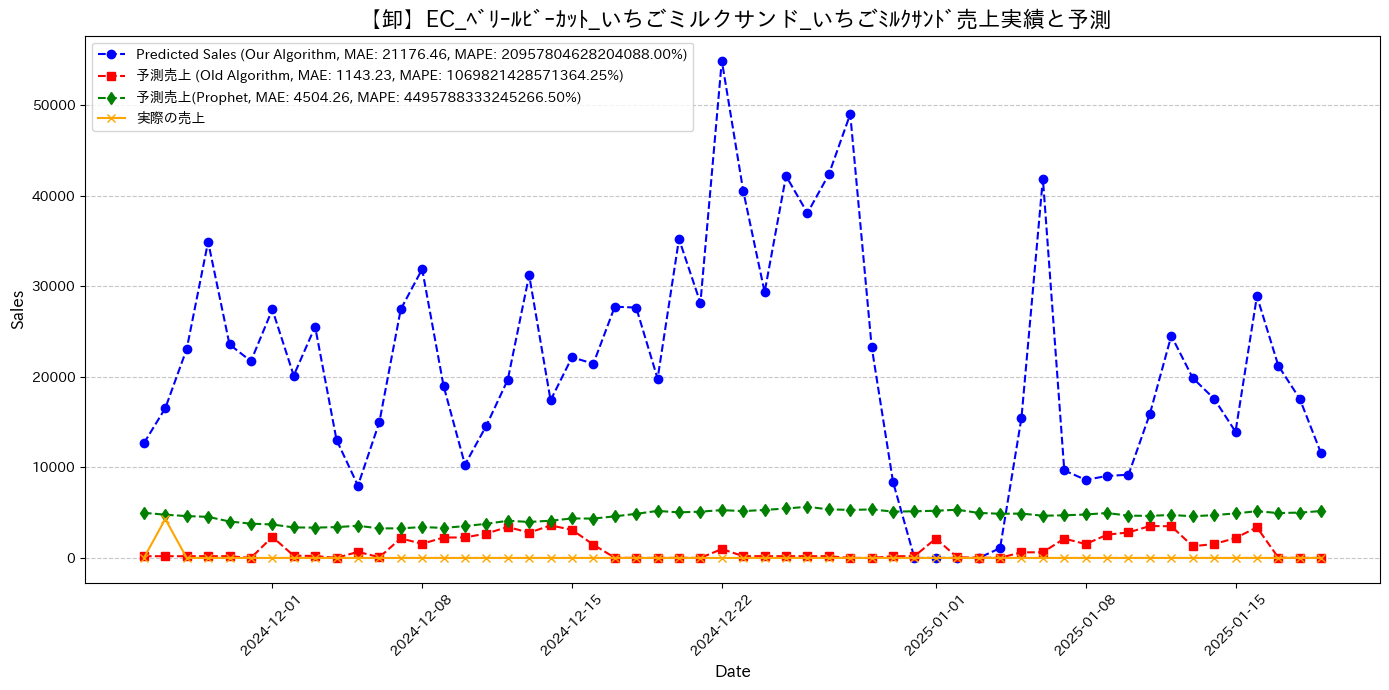

In [69]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
import japanize_matplotlib

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

EPSILON = 1e-10  # A small constant to avoid division by zero

### --- Load Actual Sales --- ###
def load_actual_sales(test_data, new_product_name):
    """ Extract actual sales for the new product from test data. """
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})
    return actual_sales

### --- Load Another Algorithm’s Predictions --- ###
def load_old_algorithm_predictions(file_path, new_product_name):
    """ Extract the prediction series for the given new product from another algorithm’s Excel file. """
    another_prediction = pd.read_excel(file_path, skiprows=0, header=None)

    # Extract product IDs from metadata
    product_ids = another_prediction.iloc[1, 1:].astype(str) + '_' + another_prediction.iloc[3, 1:].astype(str) + '_' + \
                  another_prediction.iloc[5, 1:].astype(str) + '_' + another_prediction.iloc[7, 1:].astype(str)

    # Locate column index for the new product
    if new_product_name in product_ids.values:
        column_index = product_ids[product_ids == new_product_name].index[0] + 1  # Adjust for 0-based indexing
        another_predictions_series = another_prediction.iloc[9:, column_index]  # Extract sales from row 10 onwards
        another_predictions_series = another_predictions_series.reset_index(drop=True)

        return another_predictions_series
    else:
        print("New product not found in the old algorithm’s prediction file.")
        return None

### --- Compute MAPE --- ###
def compute_mape(predictions, actuals, prediction_col):
    """Compute Mean Absolute Percentage Error (MAPE), avoiding division by zero."""
    actuals = actuals.copy()
    actuals['Actual_Sales'] = actuals['Actual_Sales'].replace(0, EPSILON)  # Replace zero actuals with a small constant
    
    # Merge actual sales data with predictions
    comparison = pd.merge(actuals, predictions[['Date', prediction_col]], on='Date', how='left')
    
    # Calculate MAPE
    comparison['APE'] = np.abs((comparison['Actual_Sales'] - comparison[prediction_col]) / comparison['Actual_Sales']) * 100
    mape = comparison['APE'].mean()
    
    return mape

### --- Compute MAE --- ###
def compute_mae(predictions, actual_sales, column_name):
    """ Compute Mean Absolute Error (MAE) between actual sales and predicted sales. """
    comparison = pd.merge(predictions, actual_sales, on='Date', how='inner')
    mae = np.mean(np.abs(comparison['Actual_Sales'] - comparison[column_name]))
    return mae

### --- Prophet Model for Prediction --- ###
def predict_sales_with_prophet(train_data, new_product_name, test_start, test_end):
    """Train a Prophet model and generate predictions for the test period."""
    
    # Prepare the data for Prophet
    df_prophet = train_data[train_data['商品ID_名前'] == new_product_name][['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)

    # Define test period for future predictions
    future_dates = pd.date_range(start=test_start, end=test_end, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})

    # Generate predictions
    forecast = prophet_model.predict(future_df)

    # Extract relevant predictions
    prophet_predictions = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Predicted_Sales_Prophet'})

    return prophet_predictions

### --- Visualization Function --- ###
def visualize_predictions(predictions_new, predictions_old, predictions_prophet, actual_sales, new_product_name):
    """
    Visualize predicted sales versus actual sales for the test period.

    Args:
    - predictions_new: DataFrame containing our algorithm's predicted sales.
    - predictions_old: DataFrame containing another algorithm’s predicted sales.
    - predictions_prophet: DataFrame containing Prophet's predicted sales.
    - actual_sales: DataFrame containing actual sales.
    - new_product_name: Name of the new product.
    """
    # Compute MAE & MAPE for all models
    mae_new = compute_mae(predictions_new, actual_sales, 'Predicted_Sales')
    mae_old = compute_mae(predictions_old, actual_sales, 'Predicted_Sales_Old')
    mae_prophet = compute_mae(predictions_prophet, actual_sales, 'Predicted_Sales_Prophet')

    mape_new = compute_mape(predictions_new, actual_sales, 'Predicted_Sales')
    mape_old = compute_mape(predictions_old, actual_sales, 'Predicted_Sales_Old')
    mape_prophet = compute_mape(predictions_prophet, actual_sales, 'Predicted_Sales_Prophet')

    print(f"MAE (Our Algorithm): {mae_new:.2f}, MAPE: {mape_new:.2f}%")
    print(f"MAE (Old Algorithm): {mae_old:.2f}, MAPE: {mape_old:.2f}%")
    print(f"MAE (Prophet): {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}%")

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot predicted sales (Our Algorithm)
    plt.plot(
        predictions_new['Date'], predictions_new['Predicted_Sales'],
        label=f'Predicted Sales (Our Algorithm, MAE: {mae_new:.2f}, MAPE: {mape_new:.2f}%)', linestyle='--', marker='o', color='blue'
    )

    # Plot predicted sales (Old Algorithm)
    plt.plot(
        predictions_old['Date'], predictions_old['Predicted_Sales_Old'],
        label=f'予測売上 (Old Algorithm, MAE: {mae_old:.2f}, MAPE: {mape_old:.2f}%)', linestyle='--', marker='s', color='red'
    )

    # Plot predicted sales (Prophet)
    plt.plot(
        predictions_prophet['Date'], predictions_prophet['Predicted_Sales_Prophet'],
        label=f'予測売上(Prophet, MAE: {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}%)', linestyle='--', marker='d', color='green'
    )

    # Plot actual sales
    plt.plot(
        actual_sales['Date'], actual_sales['Actual_Sales'],
        label='実際の売上', linestyle='-', marker='x', color='orange'
    )

    # Formatting the plot
    plt.title(f' {new_product_name}売上実績と予測', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Run everything
predictions_prophet = predict_sales_with_prophet(train_data, new_product_name, test_start, test_end)
old_file_path = "/Users/takaya/Desktop/app_wonder_palette/new_product/grs/item手法B込1年分.xlsx"  # Another algorithm’s prediction file

# Load actual sales data
actual_sales = load_actual_sales(test_data, new_product_name)

# Load another algorithm’s predictions
another_predictions_series = load_old_algorithm_predictions(old_file_path, new_product_name)

if another_predictions_series is not None:
    # Align dates for another algorithm’s predictions
    another_predictions_df = pd.DataFrame({
        'Date': actual_sales['Date'].values[:len(another_predictions_series)],  # Align with actual sales
        'Predicted_Sales_Old': another_predictions_series.values
    })

    # Predict sales for the test period using smoothed change rate and seed product 365-day composition ratio
    predictions_new = predict_new_product_sales_without_smoothing(
        train_data, final_results, seed_365_avg, final_average_change_rate, new_product_name, test_start, test_end
    )
visualize_predictions(predictions_no_smoothing, another_predictions_df, predictions_prophet, actual_sales, new_product_name)


03:45:08 - cmdstanpy - INFO - Chain [1] start processing
03:45:08 - cmdstanpy - INFO - Chain [1] done processing


start_day_month: 11-02
end_day_month: 11-24
Scaling Factor for 【卸】EC_ﾍﾞﾘｰﾙﾋﾞｰｶｯﾄ_いちごミルクサンド_いちごﾐﾙｸｻﾝﾄﾞ: 8322199.9384
seed_365_avg_filtered['シード商品365日構成比'].sum(): 0.05137416120004109
MAE (Our Algorithm): 21176.46, MAPE: 20957804628204088.00%
MAE (Old Algorithm): 1143.23, MAPE: 1069821428571364.25%
MAE (Prophet): 4504.26, MAPE: 4495788333245266.50%


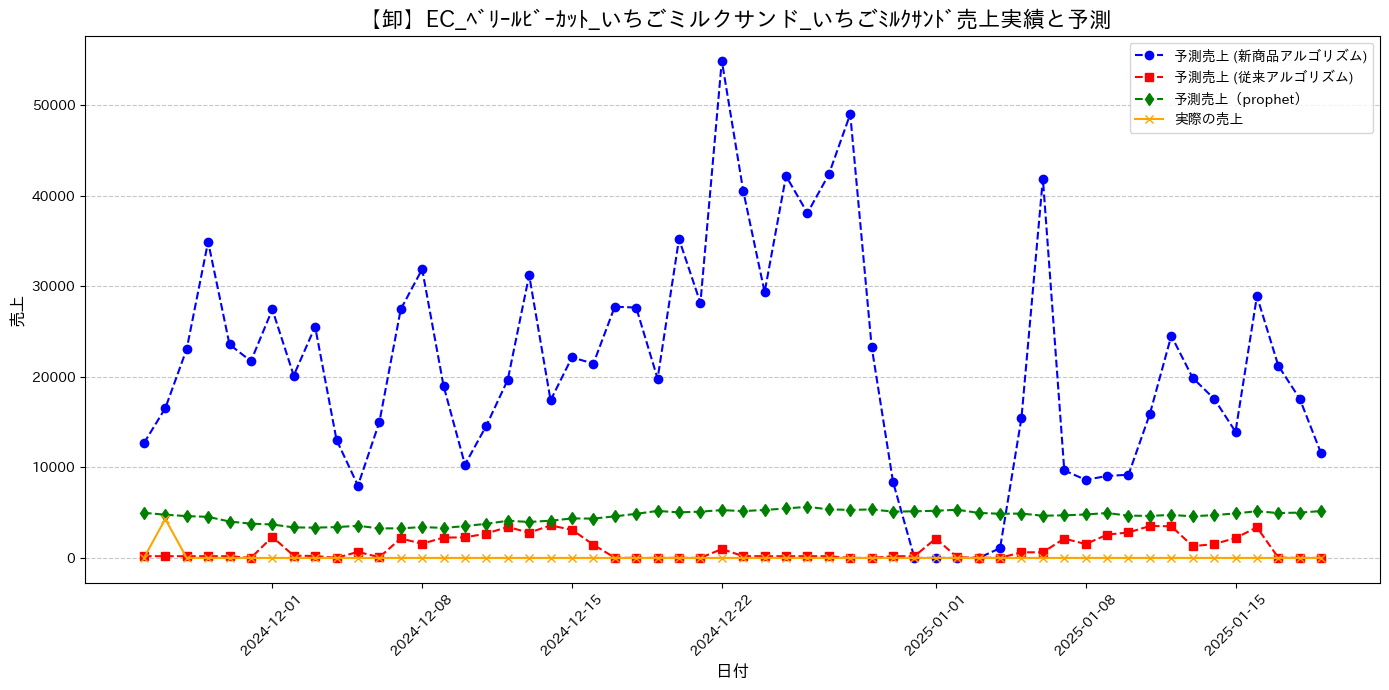

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from prophet import Prophet
import japanize_matplotlib

# Suppress warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

EPSILON = 1e-10  # A small constant to avoid division by zero

### --- Load Actual Sales --- ###
def load_actual_sales(test_data, new_product_name):
    """ Extract actual sales for the new product from test data. """
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})
    return actual_sales

### --- Load Another Algorithm’s Predictions --- ###
def load_old_algorithm_predictions(file_path, new_product_name):
    """ Extract the prediction series for the given new product from another algorithm’s Excel file. """
    another_prediction = pd.read_excel(file_path, skiprows=0, header=None)

    # Extract product IDs from metadata
    product_ids = another_prediction.iloc[1, 1:].astype(str) + '_' + another_prediction.iloc[3, 1:].astype(str) + '_' + \
                  another_prediction.iloc[5, 1:].astype(str) + '_' + another_prediction.iloc[7, 1:].astype(str)

    # Locate column index for the new product
    if new_product_name in product_ids.values:
        column_index = product_ids[product_ids == new_product_name].index[0] + 1  # Adjust for 0-based indexing
        another_predictions_series = another_prediction.iloc[9:, column_index]  # Extract sales from row 10 onwards
        another_predictions_series = another_predictions_series.reset_index(drop=True)

        return another_predictions_series
    else:
        print("New product not found in the old algorithm’s prediction file.")
        return None

### --- Compute MAPE --- ###
def compute_mape(predictions, actuals, prediction_col):
    """Compute Mean Absolute Percentage Error (MAPE), avoiding division by zero."""
    actuals = actuals.copy()
    actuals['Actual_Sales'] = actuals['Actual_Sales'].replace(0, EPSILON)  # Replace zero actuals with a small constant
    
    # Merge actual sales data with predictions
    comparison = pd.merge(actuals, predictions[['Date', prediction_col]], on='Date', how='left')
    
    # Calculate MAPE
    comparison['APE'] = np.abs((comparison['Actual_Sales'] - comparison[prediction_col]) / comparison['Actual_Sales']) * 100
    mape = comparison['APE'].mean()
    
    return mape

### --- Compute MAE --- ###
def compute_mae(predictions, actual_sales, column_name):
    """ Compute Mean Absolute Error (MAE) between actual sales and predicted sales. """
    comparison = pd.merge(predictions, actual_sales, on='Date', how='inner')
    mae = np.mean(np.abs(comparison['Actual_Sales'] - comparison[column_name]))
    return mae

### --- Prophet Model for Prediction --- ###
def predict_sales_with_prophet(train_data, new_product_name, test_start, test_end):
    """Train a Prophet model and generate predictions for the test period."""
    
    # Prepare the data for Prophet
    df_prophet = train_data[train_data['商品ID_名前'] == new_product_name][['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

    # Initialize and fit the Prophet model
    prophet_model = Prophet()
    prophet_model.fit(df_prophet)

    # Define test period for future predictions
    future_dates = pd.date_range(start=test_start, end=test_end, freq='D')
    future_df = pd.DataFrame({'ds': future_dates})

    # Generate predictions
    forecast = prophet_model.predict(future_df)

    # Extract relevant predictions
    prophet_predictions = forecast[['ds', 'yhat']].rename(columns={'ds': 'Date', 'yhat': 'Predicted_Sales_Prophet'})

    return prophet_predictions

### --- Visualization Function --- ###
def visualize_predictions(predictions_new, predictions_old, predictions_prophet, actual_sales, new_product_name):
    """
    Visualize predicted sales versus actual sales for the test period.

    Args:
    - predictions_new: DataFrame containing our algorithm's predicted sales.
    - predictions_old: DataFrame containing another algorithm’s predicted sales.
    - predictions_prophet: DataFrame containing Prophet's predicted sales.
    - actual_sales: DataFrame containing actual sales.
    - new_product_name: Name of the new product.
    """
    # Compute MAE & MAPE for all models
    mae_new = compute_mae(predictions_new, actual_sales, 'Predicted_Sales')
    mae_old = compute_mae(predictions_old, actual_sales, 'Predicted_Sales_Old')
    mae_prophet = compute_mae(predictions_prophet, actual_sales, 'Predicted_Sales_Prophet')

    mape_new = compute_mape(predictions_new, actual_sales, 'Predicted_Sales')
    mape_old = compute_mape(predictions_old, actual_sales, 'Predicted_Sales_Old')
    mape_prophet = compute_mape(predictions_prophet, actual_sales, 'Predicted_Sales_Prophet')

    print(f"MAE (Our Algorithm): {mae_new:.2f}, MAPE: {mape_new:.2f}%")
    print(f"MAE (Old Algorithm): {mae_old:.2f}, MAPE: {mape_old:.2f}%")
    print(f"MAE (Prophet): {mae_prophet:.2f}, MAPE: {mape_prophet:.2f}%")

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot predicted sales (Our Algorithm)
    plt.plot(
        predictions_new['Date'], predictions_new['Predicted_Sales'],
        label=f'予測売上 (新商品アルゴリズム)', linestyle='--', marker='o', color='blue'
    )

    # Plot predicted sales (Old Algorithm)
    plt.plot(
        predictions_old['Date'], predictions_old['Predicted_Sales_Old'],
        label=f'予測売上 (従来アルゴリズム)', linestyle='--', marker='s', color='red'
    )

    # Plot predicted sales (Prophet)
    plt.plot(
        predictions_prophet['Date'], predictions_prophet['Predicted_Sales_Prophet'],
        label=f'予測売上（prophet）', linestyle='--', marker='d', color='green'
    )

    # Plot actual sales
    plt.plot(
        actual_sales['Date'], actual_sales['Actual_Sales'],
        label='実際の売上', linestyle='-', marker='x', color='orange'
    )

    # Formatting the plot
    plt.title(f' {new_product_name}売上実績と予測', fontsize=16)
    plt.xlabel('日付', fontsize=12)
    plt.ylabel('売上', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Run everything
predictions_prophet = predict_sales_with_prophet(train_data, new_product_name, test_start, test_end)
old_file_path = "/Users/takaya/Desktop/app_wonder_palette/new_product/grs/item手法B込1年分.xlsx"  # Another algorithm’s prediction file

# Load actual sales data
actual_sales = load_actual_sales(test_data, new_product_name)

# Load another algorithm’s predictions
another_predictions_series = load_old_algorithm_predictions(old_file_path, new_product_name)

if another_predictions_series is not None:
    # Align dates for another algorithm’s predictions
    another_predictions_df = pd.DataFrame({
        'Date': actual_sales['Date'].values[:len(another_predictions_series)],  # Align with actual sales
        'Predicted_Sales_Old': another_predictions_series.values
    })

    # Predict sales for the test period using smoothed change rate and seed product 365-day composition ratio
    predictions_new = predict_new_product_sales_without_smoothing(
        train_data, final_results, seed_365_avg, final_average_change_rate, new_product_name, test_start, test_end
    )
visualize_predictions(predictions_no_smoothing, another_predictions_df, predictions_prophet, actual_sales, new_product_name)


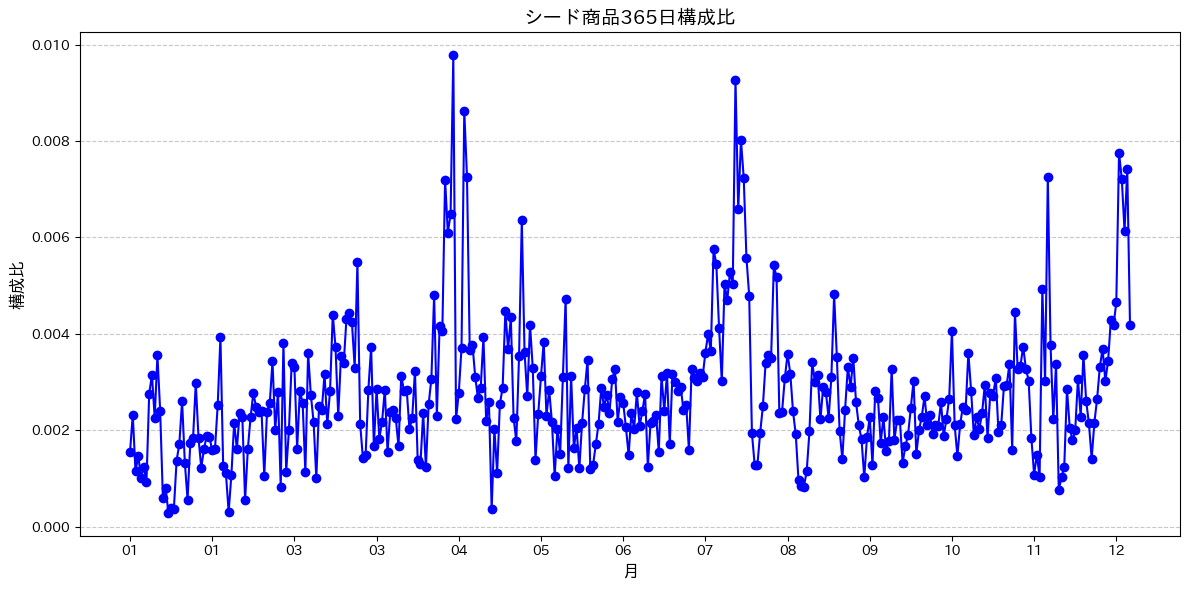

In [26]:
import matplotlib.pyplot as plt
import japanize_matplotlib

# Extract the month from the 'Day-Month' column
seed_365_avg['Month'] = seed_365_avg['Day-Month'].str.split('-').str[0]

# Plot the seed product 365-day composition ratio
plt.figure(figsize=(12, 6))
plt.plot(seed_365_avg['Day-Month'], seed_365_avg['シード商品365日構成比'], marker='o', linestyle='-', color='blue')

# Formatting the plot
plt.title("シード商品365日構成比", fontsize=14)
plt.xlabel("月", fontsize=12)
plt.ylabel("構成比", fontsize=12)

# Set x-ticks to show only months, reducing label clutter
plt.xticks(ticks=seed_365_avg.index[::30], labels=seed_365_avg['Month'][::30], rotation=0, fontsize=10)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()



MAPE: inf%


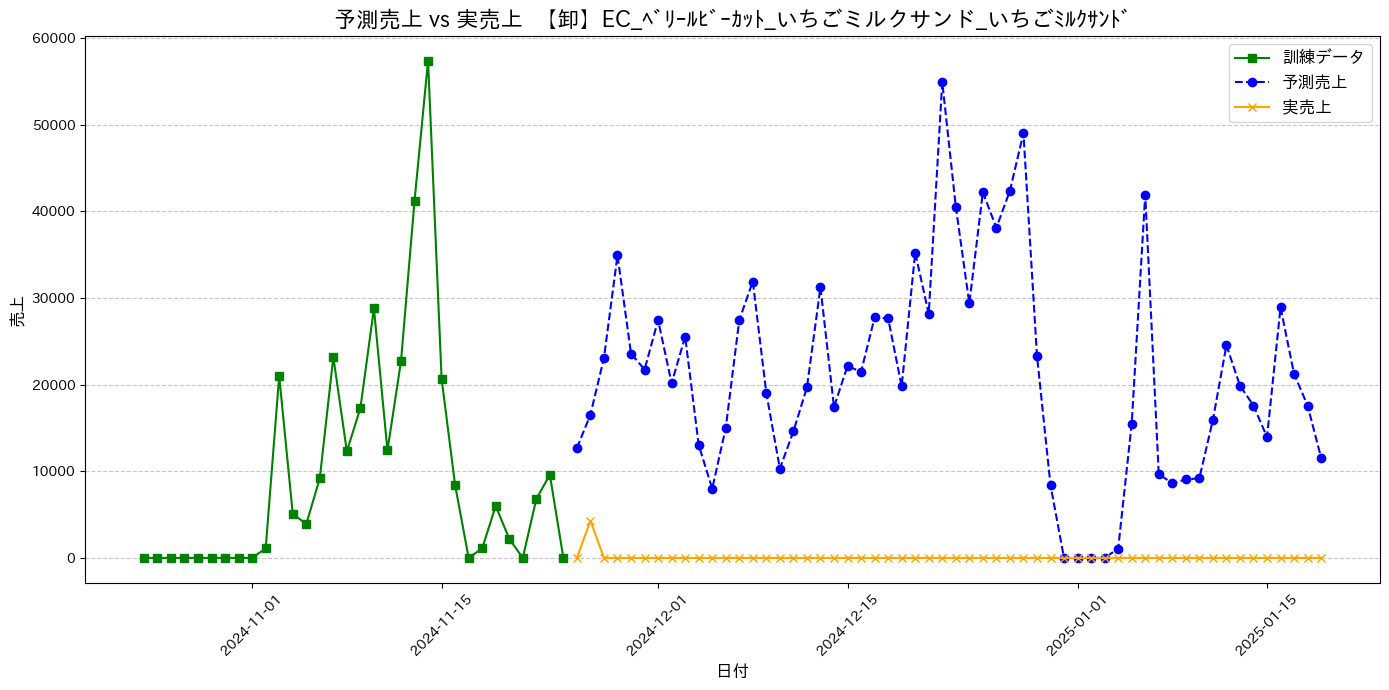

In [71]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd
import japanize_matplotlib

# Suppress all warnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def visualize_predictions(predictions, test_data, train_data, new_product_name):
    """
    Visualize predicted sales versus actual sales for the test period,
    including the last 2 months of training data.

    Args:
    - predictions: DataFrame containing predicted sales with columns ['Date', 'Predicted_Sales'].
    - test_data: DataFrame containing actual sales data with columns ['Date', 'Sales', '商品ID_名前'].
    - train_data: DataFrame containing historical sales data.
    - new_product_name: Name of the new product to filter actual sales data.
    """
    # Ensure Date column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])
    predictions['Date'] = pd.to_datetime(predictions['Date'])

    # Filter actual sales data for the new product and test period
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})

    # Merge predictions with actual sales
    comparison = pd.merge(predictions, actual_sales, on='Date', how='left')

    # Extract last 2 months of training data for the new product
    train_end_date = train_data['Date'].max()
    train_start_date = train_end_date - pd.DateOffset(months=1)
    train_sales = train_data[
        (train_data['商品ID_名前'] == new_product_name) &
        (train_data['Date'] >= train_start_date)
    ][['Date', 'Sales']].rename(columns={'Sales': 'Train_Sales'})

    # Merge with comparison dataframe
    comparison = pd.merge(comparison, train_sales, on='Date', how='outer')

    # Calculate MAPE (Mean Absolute Percentage Error)
    comparison['APE'] = np.abs((comparison['Actual_Sales'] - comparison['Predicted_Sales']) / comparison['Actual_Sales']) * 100
    mape = comparison['APE'].mean()

    print(f"MAPE: {mape:.2f}%")

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot training sales (last 2 months)
    plt.plot(
        comparison['Date'], comparison['Train_Sales'],
        label='訓練データ', linestyle='-', marker='s', color='green'
    )

    # Plot predicted sales
    plt.plot(
        comparison['Date'], comparison['Predicted_Sales'],
        label='予測売上', linestyle='--', marker='o', color='blue'
    )

    # Plot actual sales
    plt.plot(
        comparison['Date'], comparison['Actual_Sales'],
        label='実売上', linestyle='-', marker='x', color='orange'
    )


    # Formatting the plot
    plt.title(f'予測売上 vs 実売上  {new_product_name}', fontsize=16)
    plt.xlabel('日付', fontsize=12)
    plt.ylabel('売上', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Visualize predictions versus actual sales including last 2 months of training data
visualize_predictions(predictions_no_smoothing, test_data, train_data, new_product_name)


MAPE: 82.23%


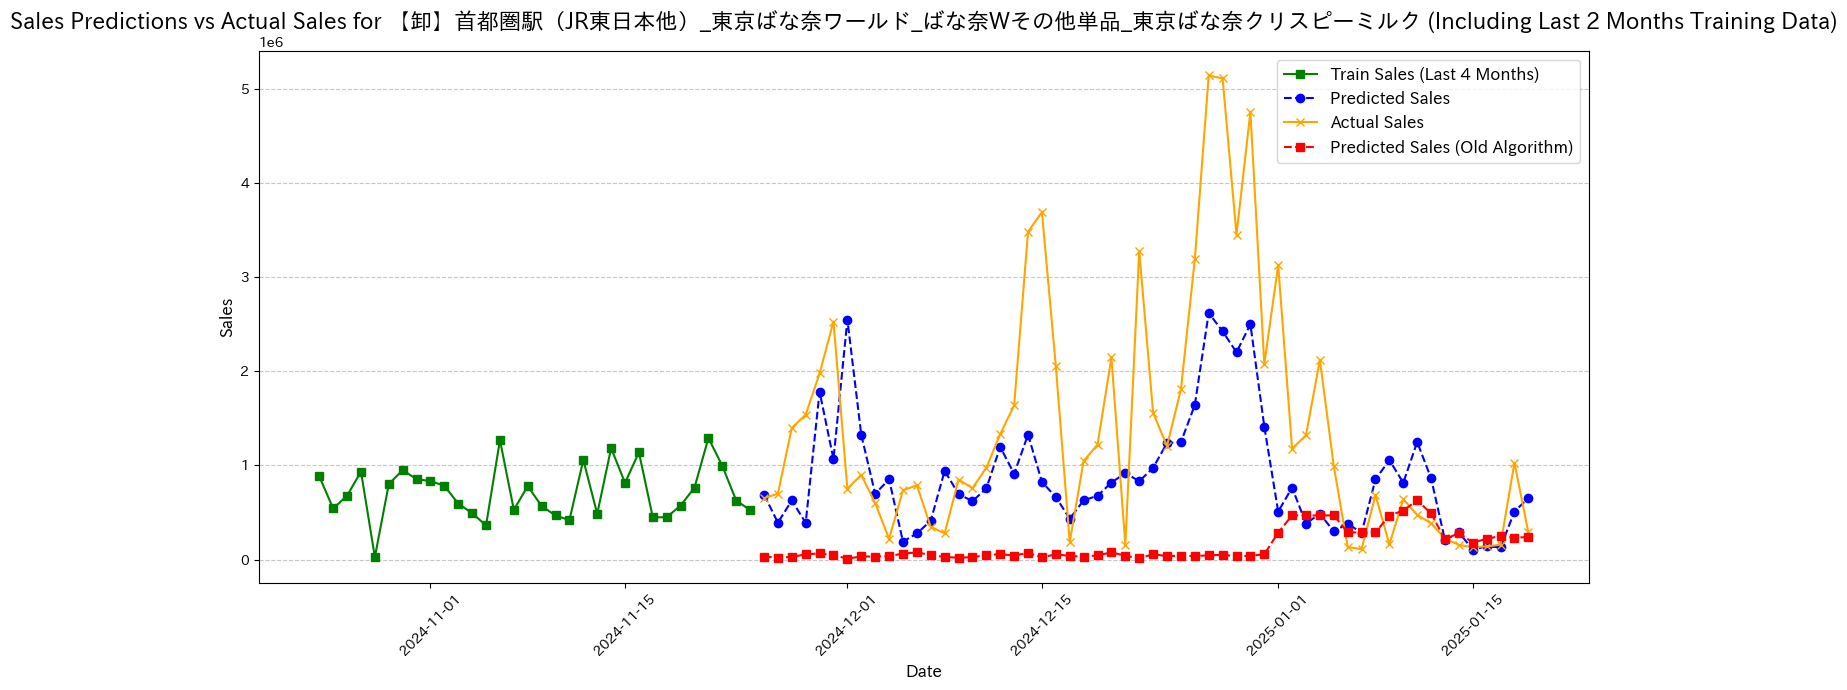

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd

# Suppress all warnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def visualize_predictions(predictions, test_data, train_data, new_product_name):
    """
    Visualize predicted sales versus actual sales for the test period,
    including the last 2 months of training data.

    Args:
    - predictions: DataFrame containing predicted sales with columns ['Date', 'Predicted_Sales'].
    - test_data: DataFrame containing actual sales data with columns ['Date', 'Sales', '商品ID_名前'].
    - train_data: DataFrame containing historical sales data.
    - new_product_name: Name of the new product to filter actual sales data.
    """
    # Ensure Date column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])
    predictions['Date'] = pd.to_datetime(predictions['Date'])

    # Filter actual sales data for the new product and test period
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})

    # Merge predictions with actual sales
    comparison = pd.merge(predictions, actual_sales, on='Date', how='left')

    # Extract last 2 months of training data for the new product
    train_end_date = train_data['Date'].max()
    train_start_date = train_end_date - pd.DateOffset(months=1)
    train_sales = train_data[
        (train_data['商品ID_名前'] == new_product_name) &
        (train_data['Date'] >= train_start_date)
    ][['Date', 'Sales']].rename(columns={'Sales': 'Train_Sales'})

    # Load another algorithm’s predictions
    another_predictions_series = load_old_algorithm_predictions(old_file_path, new_product_name)

    if another_predictions_series is not None:
        # Align dates for another algorithm’s predictions
        another_predictions_df = pd.DataFrame({
            'Date': actual_sales['Date'].values[:len(another_predictions_series)],  # Align with actual sales
            'Predicted_Sales_Old': another_predictions_series.values
        })
    # Merge with comparison dataframe
    comparison = pd.merge(comparison, train_sales, on='Date', how='outer')

    # Calculate MAPE (Mean Absolute Percentage Error)
    comparison['APE'] = np.abs((comparison['Actual_Sales'] - comparison['Predicted_Sales']) / comparison['Actual_Sales']) * 100
    mape = comparison['APE'].mean()

    print(f"MAPE: {mape:.2f}%")

    # Plot the results
    plt.figure(figsize=(14, 7))

    # Plot training sales (last 2 months)
    plt.plot(
        comparison['Date'], comparison['Train_Sales'],
        label='Train Sales (Last 4 Months)', linestyle='-', marker='s', color='green'
    )

    # Plot predicted sales
    plt.plot(
        comparison['Date'], comparison['Predicted_Sales'],
        label='Predicted Sales', linestyle='--', marker='o', color='blue'
    )

    # Plot actual sales
    plt.plot(
        comparison['Date'], comparison['Actual_Sales'],
        label='Actual Sales', linestyle='-', marker='x', color='orange'
    )

    # Plot predicted sales (Old Algorithm)
    plt.plot(
        another_predictions_df['Date'], another_predictions_df['Predicted_Sales_Old'],
        label=f'Predicted Sales (Old Algorithm)', linestyle='--', marker='s', color='red'
    )


    # Formatting the plot
    plt.title(f'Sales Predictions vs Actual Sales for {new_product_name} (Including Last 2 Months Training Data)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Visualize predictions versus actual sales including last 2 months of training data
visualize_predictions(predictions_no_smoothing, test_data, train_data, new_product_name)


MAPE: inf%


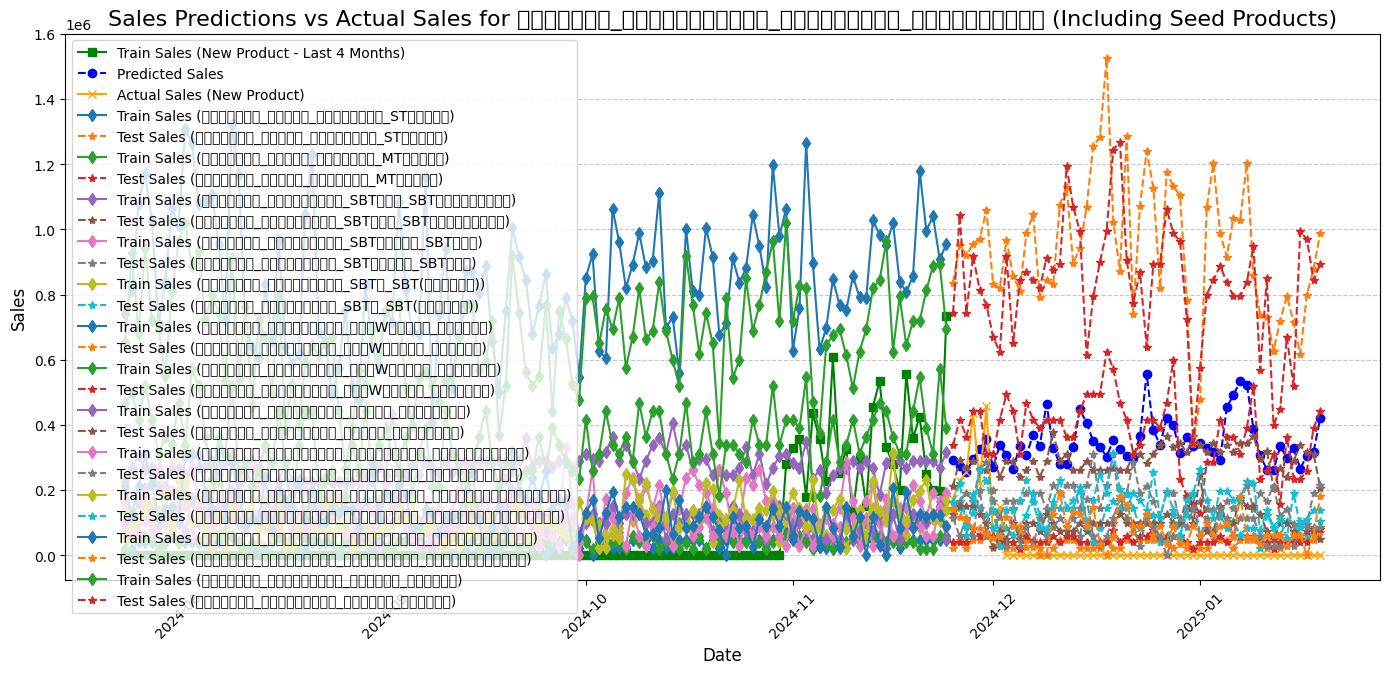

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import warnings
import pandas as pd

# Suppress all warnings globally
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
pd.options.mode.chained_assignment = None  # Suppress SettingWithCopyWarning

def visualize_predictions(predictions, test_data, train_data, seed_products, new_product_name):
    """
    Visualize predicted sales versus actual sales for the test period,
    including the last 4 months of training data and sales for each seed product.

    Args:
    - predictions: DataFrame containing predicted sales with columns ['Date', 'Predicted_Sales'].
    - test_data: DataFrame containing actual sales data with columns ['Date', 'Sales', '商品ID_名前'].
    - train_data: DataFrame containing historical sales data.
    - seed_products: List of seed product names to include in the visualization.
    - new_product_name: Name of the new product to filter actual sales data.
    """
    # Ensure Date column is in datetime format
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    test_data['Date'] = pd.to_datetime(test_data['Date'])
    predictions['Date'] = pd.to_datetime(predictions['Date'])

    # Define train and test date ranges
    train_end_date = train_data['Date'].max()
    train_start_date = train_end_date - pd.DateOffset(months=4)
    test_start_date = predictions['Date'].min()
    test_end_date = predictions['Date'].max()

    ### --- New Product Sales --- ###
    # Filter actual sales data for the new product in the test period
    actual_sales = test_data[test_data['商品ID_名前'] == new_product_name][['Date', 'Sales']]
    actual_sales = actual_sales.rename(columns={'Sales': 'Actual_Sales'})

    # Merge predictions with actual sales
    comparison = pd.merge(predictions, actual_sales, on='Date', how='left')

    # Extract last 4 months of training data for the new product
    train_sales = train_data[
        (train_data['商品ID_名前'] == new_product_name) &
        (train_data['Date'] >= train_start_date)
    ][['Date', 'Sales']].rename(columns={'Sales': 'Train_Sales'})

    # Merge with comparison dataframe
    comparison = pd.merge(comparison, train_sales, on='Date', how='outer')

    ### --- Compute MAPE --- ###
    comparison['APE'] = np.abs((comparison['Actual_Sales'] - comparison['Predicted_Sales']) / comparison['Actual_Sales']) * 100
    mape = comparison['APE'].mean()

    print(f"MAPE: {mape:.2f}%")

    ### --- Plot the results --- ###
    plt.figure(figsize=(14, 7))

    # Plot training sales (Last 4 months, new product)
    plt.plot(
        comparison['Date'], comparison['Train_Sales'],
        label='Train Sales (New Product - Last 4 Months)', linestyle='-', marker='s', color='green'
    )

    # Plot predicted sales
    plt.plot(
        comparison['Date'], comparison['Predicted_Sales'],
        label='Predicted Sales', linestyle='--', marker='o', color='blue'
    )

    # Plot actual sales
    plt.plot(
        comparison['Date'], comparison['Actual_Sales'],
        label='Actual Sales (New Product)', linestyle='-', marker='x', color='orange'
    )

    ### --- Plot Each Seed Product Separately --- ###
    for seed_product in seed_products:
        # Get training sales for seed product
        seed_train_sales = train_data[
            (train_data['商品ID_名前'] == seed_product) & (train_data['Date'] >= train_start_date)
        ][['Date', 'Sales']].rename(columns={'Sales': f'Train_{seed_product}'})

        # Get test sales for seed product
        seed_test_sales = test_data[
            (test_data['商品ID_名前'] == seed_product) & (test_data['Date'] >= test_start_date)
        ][['Date', 'Sales']].rename(columns={'Sales': f'Test_{seed_product}'})

        # Merge with comparison dataframe
        comparison = pd.merge(comparison, seed_train_sales, on='Date', how='outer')
        comparison = pd.merge(comparison, seed_test_sales, on='Date', how='outer')

        # Plot seed product training sales
        plt.plot(
            comparison['Date'], comparison[f'Train_{seed_product}'],
            label=f'Train Sales ({seed_product})', linestyle='-', marker='d'
        )

        # Plot seed product test sales
        plt.plot(
            comparison['Date'], comparison[f'Test_{seed_product}'],
            label=f'Test Sales ({seed_product})', linestyle='--', marker='*'
        )

    # Formatting the plot
    plt.title(f'Sales Predictions vs Actual Sales for {new_product_name} (Including Seed Products)', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Sales', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.xticks(rotation=45, fontsize=10)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Example execution
visualize_predictions(predictions_no_smoothing, test_data, train_data, seed_products, new_product_name)


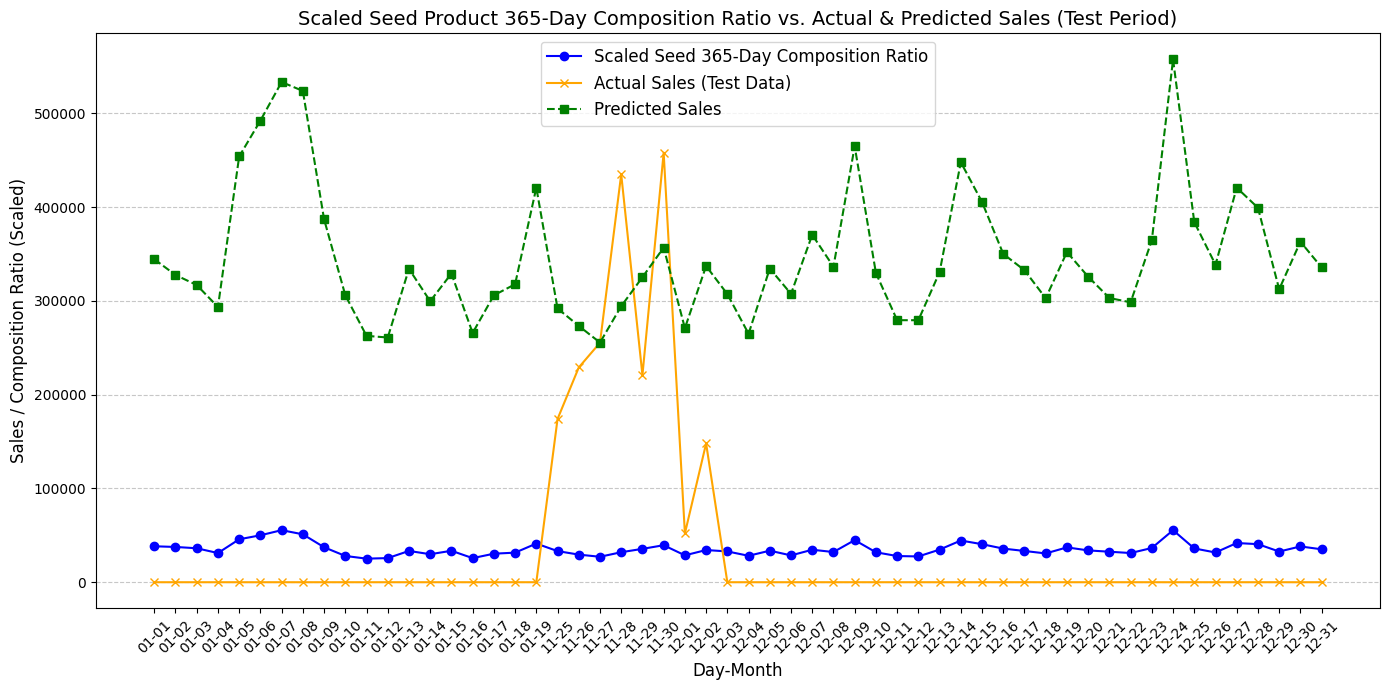

In [58]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_scaled_seed_365_composition_for_test_period(seed_365_avg, actual_sales, predictions, test_start, test_end):
    """
    Plot the seed product 365-day composition ratio for the test period only, 
    scaling it dynamically to match actual sales for better visualization.

    Args:
    - seed_365_avg: DataFrame containing the 365-day composition ratio with columns ['Day-Month', 'シード商品365日構成比'].
    - actual_sales: DataFrame containing actual sales for the test period with columns ['Date', 'Actual_Sales'].
    - predictions: DataFrame containing predicted sales with columns ['Date', 'Predicted_Sales'].
    - test_start: Start date of the test period (YYYY-MM-DD).
    - test_end: End date of the test period (YYYY-MM-DD).
    """

    # Ensure Date column is in datetime format
    test_start = pd.to_datetime(test_start)
    test_end = pd.to_datetime(test_end)
    
    actual_sales['Date'] = pd.to_datetime(actual_sales['Date'])
    predictions['Date'] = pd.to_datetime(predictions['Date'])

    # Convert actual sales and predictions to match the format of seed_365_avg
    actual_sales['Day-Month'] = actual_sales['Date'].dt.strftime('%m-%d')
    predictions['Day-Month'] = predictions['Date'].dt.strftime('%m-%d')

    # Split the test period into two parts: (1) Nov 25 - Dec 31 and (2) Jan 1 - Jan 19
    test_period_1 = (seed_365_avg['Day-Month'] >= "11-25") & (seed_365_avg['Day-Month'] <= "12-31")
    test_period_2 = (seed_365_avg['Day-Month'] >= "01-01") & (seed_365_avg['Day-Month'] <= "01-19")

    # Filter seed_365_avg for these two periods
    seed_365_avg_filtered = seed_365_avg[test_period_1 | test_period_2]

    # Merge actual sales and predictions with the filtered seed product composition ratio
    merged_data = pd.merge(seed_365_avg_filtered, actual_sales, on='Day-Month', how='left')
    merged_data = pd.merge(merged_data, predictions, on='Day-Month', how='left')

    # **Dynamically scale the seed composition ratio to match actual sales**
    actual_sales_sum = merged_data['Actual_Sales'].sum()
    seed_ratio_sum = merged_data['シード商品365日構成比'].sum()
    scaling_factor = actual_sales_sum / seed_ratio_sum if seed_ratio_sum > 0 else 1
    merged_data['Scaled_Seed_Ratio'] = merged_data['シード商品365日構成比'] * scaling_factor

    # **Plot the scaled seed product 365-day composition ratio vs. actual and predicted sales**
    plt.figure(figsize=(14, 7))

    # Plot scaled seed product 365-day composition ratio
    plt.plot(
        merged_data['Day-Month'], merged_data['Scaled_Seed_Ratio'],
        marker='o', linestyle='-', color='blue', label="Scaled Seed 365-Day Composition Ratio"
    )

    # Plot actual sales
    plt.plot(
        merged_data['Day-Month'], merged_data['Actual_Sales'],
        marker='x', linestyle='-', color='orange', label="Actual Sales (Test Data)"
    )

    # Plot predicted sales
    plt.plot(
        merged_data['Day-Month'], merged_data['Predicted_Sales'],
        marker='s', linestyle='--', color='green', label="Predicted Sales"
    )

    # Formatting the plot
    plt.title("Scaled Seed Product 365-Day Composition Ratio vs. Actual & Predicted Sales (Test Period)", fontsize=14)
    plt.xlabel("Day-Month", fontsize=12)
    plt.ylabel("Sales / Composition Ratio (Scaled)", fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # Show the plot
    plt.show()

# Load actual sales data
actual_sales = load_actual_sales(test_data, new_product_name)

# Execute the function with actual sales and predictions for the test period
plot_scaled_seed_365_composition_for_test_period(seed_365_avg, actual_sales, predictions_no_smoothing, test_start, test_end)
